## 1. Load Libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import pickle
import squarify
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## 2. Load file RFM and stats

In [2]:
df = pd.read_csv('df_RFM.csv')
df.head(3)

,Member_number,Recency,Frequency,Monetary
0,2433,3,31,375.31
1,2193,91,27,361.45
2,1793,26,25,345.10


In [3]:
df.describe()

,Member_number,Recency,Frequency,Monetary
count,3898.000000,3898.000000,3898.000000,3898.000000
mean,3002.959979,187.701385,9.944844,85.212835
std,1155.806001,159.912688,5.310796,55.620089
min,1000.000000,0.000000,2.000000,1.300000
25%,1999.250000,57.000000,6.000000,43.810000
50%,3004.500000,141.000000,9.000000,74.900000
75%,4002.750000,280.000000,13.000000,115.295000
max,5000.000000,727.000000,36.000000,375.310000


In [4]:
#confirm null values and duplicate values
print(f"There has {df.isna().sum()} null values")
print(f"There has {df.duplicated().sum()} duplicated values")

There has Member_number    0
Recency          0
Frequency        0
Monetary         0
dtype: int64 null values
There has 0 duplicated values


## 3. Scale data and training model

#### 3.1. Scale data

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Recency', 'Frequency', 'Monetary']])

##### 3.2. Elbow method and Silhouette Score

* KMeans

In [6]:
sse = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))


In [7]:
kl = KneeLocator(k_values, sse, curve='convex', direction='decreasing')
print(f"The optimal number of clusters is : {kl.elbow}")

The optimal number of clusters is : 4


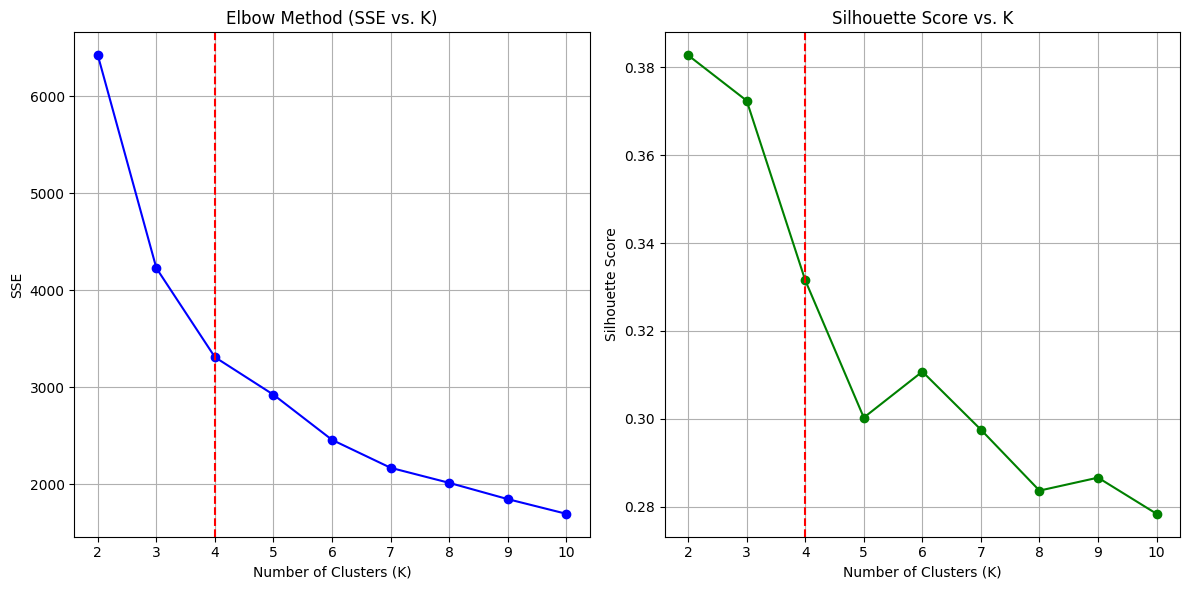

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o', color='b')
plt.title("Elbow Method (SSE vs. K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE")
plt.axvline(x=kl.elbow, color='r', linestyle='--', label=f'Optimal k = {kl.elbow}')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='g')
plt.title("Silhouette Score vs. K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.axvline(x=kl.elbow, color='r', linestyle='--', label=f'Optimal k = {kl.elbow}')
plt.grid(True)

plt.tight_layout()
plt.show()


* GMM

In [9]:
silhouette_scores_gmm = []
bic_scores = []
aic_scores = []
k_values = range(2, 11)

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaled_data)
    gmm_labels = gmm.predict(scaled_data)
    silhouette_scores_gmm.append(silhouette_score(scaled_data, gmm_labels))
    bic_scores.append(gmm.bic(scaled_data))
    aic_scores.append(gmm.aic(scaled_data))

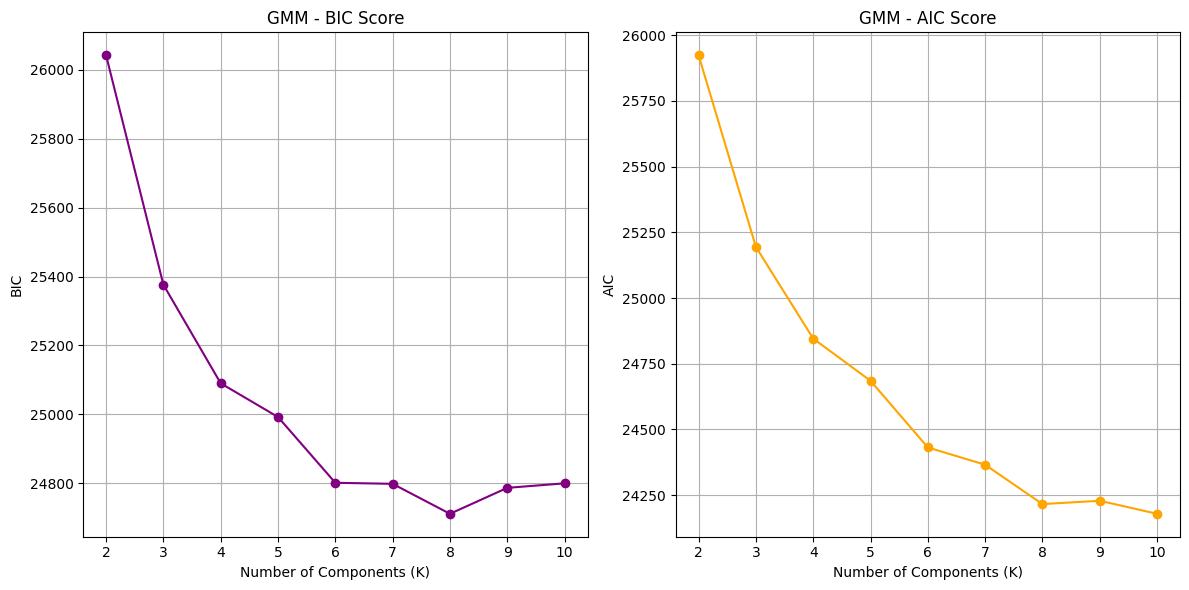

In [20]:
# BIC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, bic_scores, marker='o', color='purple')
plt.title("GMM - BIC Score")
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC")
plt.grid(True)

# AIC
plt.subplot(1, 2, 2)
plt.plot(k_values, aic_scores, marker='o', color='orange')
plt.title("GMM - AIC Score")
plt.xlabel("Number of Components (K)")
plt.ylabel("AIC")
plt.grid(True)

plt.tight_layout()
plt.show()

* Conclusion

In [11]:
k = 3
k_index = k_values.index(k)
print(f"*KMeans - k = {k}:")
print(f"  SSE: {sse[k_index]}")
print(f"  Silhouette Score: {silhouette_scores[k_index]}")
print()
print(f"*GMM - k = {k}:")
print(f"  Silhouette Score: {silhouette_scores_gmm[k_index]}")
print(f"  BIC: {bic_scores[k_index]}")
print(f"  AIC: {aic_scores[k_index]}")

print("-"*50)
k = 4
k_index = k_values.index(k)
print(f"*KMeans - k = {k}:")
print(f"  SSE: {sse[k_index]}")
print(f"  Silhouette Score: {silhouette_scores[k_index]}")
print()
print(f"*GMM - k = {k}:")
print(f"  Silhouette Score: {silhouette_scores_gmm[k_index]}")
print(f"  BIC: {bic_scores[k_index]}")
print(f"  AIC: {aic_scores[k_index]}")

*KMeans - k = 3:
  SSE: 4227.171654366288
  Silhouette Score: 0.3724062656386269

*GMM - k = 3:
  Silhouette Score: 0.2707556446583158
  BIC: 25376.36168569913
  AIC: 25194.58333817717
--------------------------------------------------
*KMeans - k = 4:
  SSE: 3309.4034383519947
  Silhouette Score: 0.3315363153721013

*GMM - k = 4:
  Silhouette Score: 0.238545325307581
  BIC: 25090.15059992483
  AIC: 24845.690063602196


##### Comments: 
- Firstly, though k = 3 has higher silhouette score, but in the elbow method, it is clearly visible that k = 4 is the cut off point which indicates that cluster 4 might be better 
- In addition, in GMM model, the lower BIC and AIC score, the more fitting => should choose 4 
- Finally, because the silhouette score of GMM is smaller than silhouette score of Kmeans, it demonstrates that Kmeans works better than GMM

#### 3.2. Train models

In [12]:
k = 4
kmeans_model = KMeans(n_clusters=k, random_state=42)
kmeans_model.fit(scaled_data)

gmm_model = GaussianMixture(n_components=k, random_state=42)
gmm_model.fit(scaled_data)

GaussianMixture(n_components=4, random_state=42)

In [13]:
with open('kmeans_model_4.pkl', 'wb') as file:
    pickle.dump(kmeans_model, file)

with open('gmm_model_4.pkl', 'wb') as file:
    pickle.dump(gmm_model, file)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

#### 3.3. Customer clustering visualization

* Kmeans

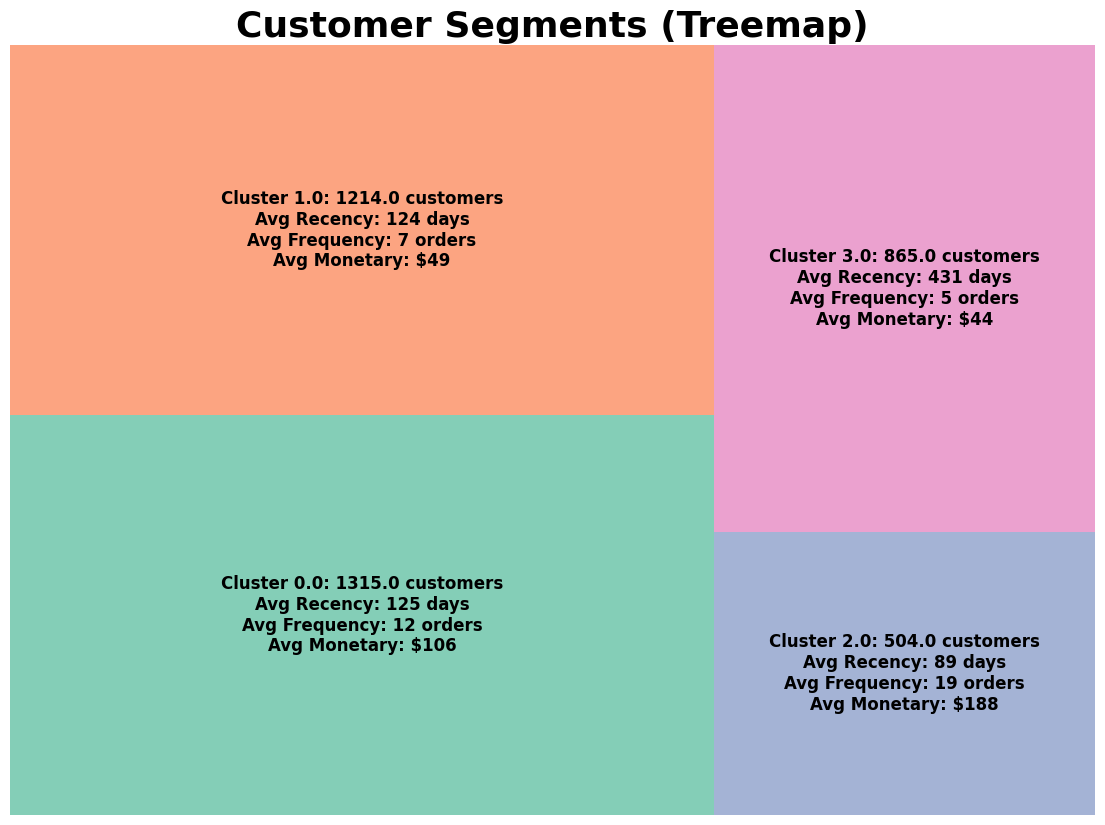

In [22]:
df['cluster'] = kmeans_model.predict(scaled_data)

# Cluster summary
cluster_summary = df.groupby('cluster').agg(
    Count=('cluster', 'size'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean')
).reset_index()

# Create labels
cluster_summary['label'] = [
    f"Cluster {row['cluster']}: {row['Count']} customers\nAvg Recency: {row['Avg_Recency']:.0f} days\nAvg Frequency: {row['Avg_Frequency']:.0f} orders\nAvg Monetary: ${row['Avg_Monetary']:.0f}"
    for _, row in cluster_summary.iterrows()
]

# Assign different colors using seaborn or matplotlib colormap
num_clusters = cluster_summary.shape[0]
colors = sns.color_palette("Set2", n_colors=num_clusters).as_hex()  # or use "Set3", "tab10", etc.

# Plot treemap with colors
fig = plt.figure(figsize=(14, 10))
squarify.plot(
    sizes=cluster_summary['Count'],
    label=cluster_summary['label'],
    color=colors,
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'fontname': "sans serif"},
    alpha=0.8
)

plt.title("Customer Segments (Treemap)", fontsize=26, fontweight="bold")
plt.axis('off')
plt.show()

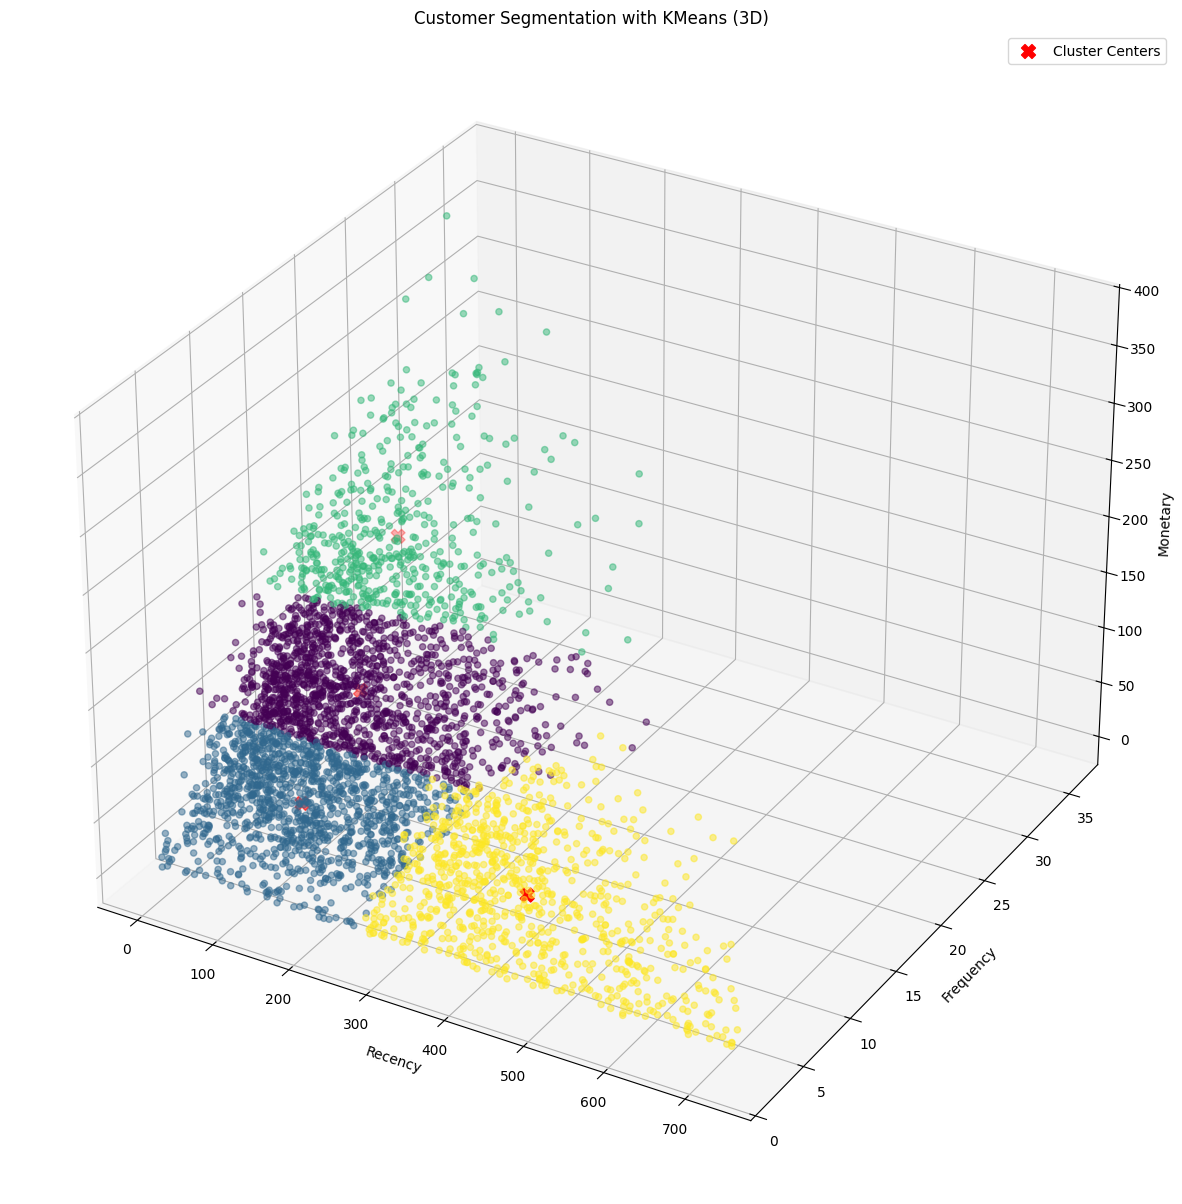

In [23]:
# Create the figure for 3D plotting
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the customer points (Recency, Frequency, Monetary)
scatter = ax.scatter(
    df['Recency'], df['Frequency'], df['Monetary'],
    c=df['cluster'], cmap='viridis', alpha=0.5
)

# Plot the cluster centroids
centroids = kmeans_model.cluster_centers_
centers = scaler.inverse_transform(centroids)

# Plot the centers only with Recency, Frequency, and Monetary (3D)
ax.scatter(
    centers[:, 0], centers[:, 1], centers[:, 2],
    c='red', s=100, marker='X', label='Cluster Centers'
)

# Set labels and title for the plot
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Customer Segmentation with KMeans (3D)')

# Add a legend
ax.legend()

# Show the plot
plt.show()

* GMM

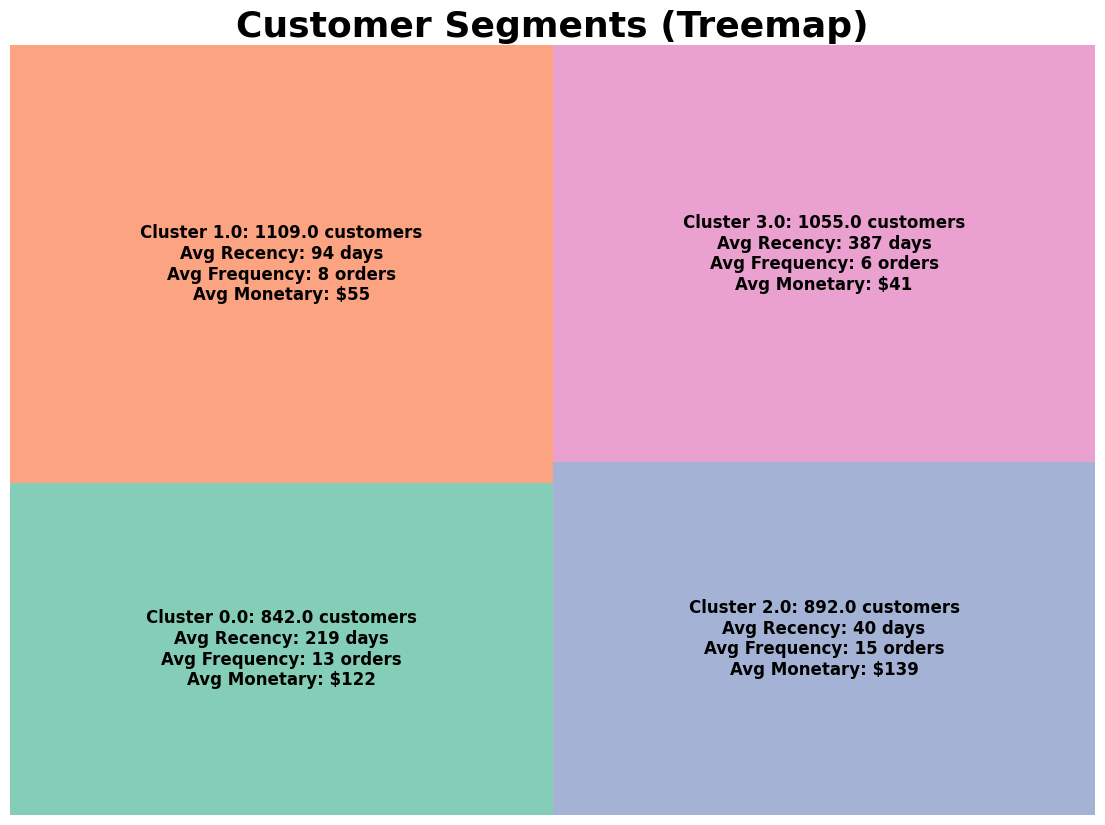

In [ ]:
df['cluster'] = gmm_model.predict(scaled_data)

# Cluster summary
cluster_summary = df.groupby('cluster').agg(
    Count=('cluster', 'size'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean')
).reset_index()

# Create labels
cluster_summary['label'] = [
    f"Cluster {row['cluster']}: {row['Count']} customers\nAvg Recency: {row['Avg_Recency']:.0f} days\nAvg Frequency: {row['Avg_Frequency']:.0f} orders\nAvg Monetary: ${row['Avg_Monetary']:.0f}"
    for _, row in cluster_summary.iterrows()
]

num_clusters = cluster_summary.shape[0]
colors = sns.color_palette("Set2", n_colors=num_clusters).as_hex()  

# Plot treemap with colors
fig = plt.figure(figsize=(14, 10))
squarify.plot(
    sizes=cluster_summary['Count'],
    label=cluster_summary['label'],
    color=colors,
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'fontname': "sans serif"},
    alpha=0.8
)

plt.title("Customer Segments (Treemap)", fontsize=26, fontweight="bold")
plt.axis('off')
plt.show()

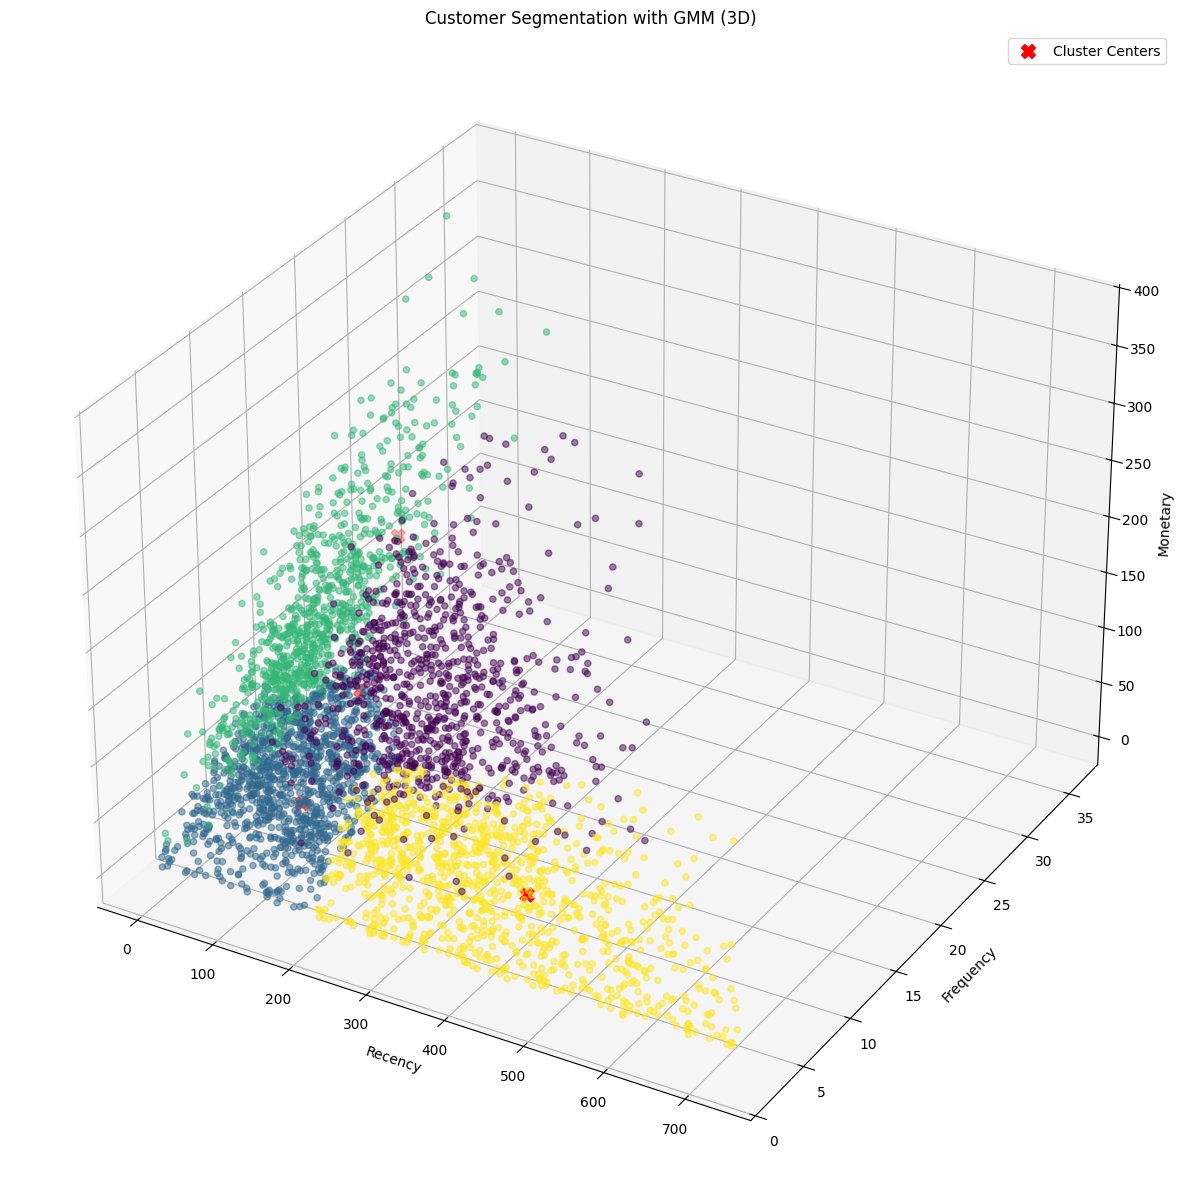

In [25]:
# Create the figure for 3D plotting
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the customer points (Recency, Frequency, Monetary)
scatter = ax.scatter(
    df['Recency'], df['Frequency'], df['Monetary'],
    c=df['cluster'], cmap='viridis', alpha=0.5
)

# Plot the cluster centroids
centroids = kmeans_model.cluster_centers_
centers = scaler.inverse_transform(centroids)

# Plot the centers only with Recency, Frequency, and Monetary (3D)
ax.scatter(
    centers[:, 0], centers[:, 1], centers[:, 2],
    c='red', s=100, marker='X', label='Cluster Centers'
)

# Set labels and title for the plot
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Customer Segmentation with GMM (3D)')

# Add a legend
ax.legend()

# Show the plot
plt.show()